# 진행 배경
- c_12, c_14, c_13 세 개를 비교했을 때 논리적으로 앞뒤가 맞지 않는 경우 일부 존재
- 해당 경우들을 찾아낸 후, 전처리 시 삭제 예정 (train데이터만! test는 안건드림)

# 0. 작업 전 데이터 전처리

In [1]:
# 데이터 불러오고 카피 생성
df_raw = pd.read_csv("../../../insurance_fraud_detect_data.csv")
df_raw.columns = ["c_"+str(i) for i in range(1,26)]
df = df_raw.copy()

In [2]:
# 헷갈리니 c_12, c_13, c_14 순서 순으로 다시 범주화
# c_12
df["c_12"].replace(2, 10, inplace=True) 
df["c_12"].replace(3, 2, inplace=True) 
df["c_12"].replace(4, 3, inplace=True)
df["c_12"].replace(5, 4, inplace=True)
df["c_12"].replace(6, 5, inplace=True)
df["c_12"].replace(10, 6, inplace=True)


# c_14
df["c_14"].replace(2, 10, inplace=True) 
df["c_14"].replace(3, 2, inplace=True) 
df["c_14"].replace(4, 3, inplace=True) 
df["c_14"].replace(5, 4, inplace=True) 
df["c_14"].replace(6, 5, inplace=True) 
df["c_14"].replace(10, 6, inplace=True)


# c_13
df["c_13"].replace(5, 10, inplace=True)
df["c_13"].replace(4, 5, inplace=True) 
df["c_13"].replace(3, 4, inplace=True) 
df["c_13"].replace(2, 3, inplace=True) 
df["c_13"].replace(1, 2, inplace=True) 
df["c_13"].replace(10, 1, inplace=True)

In [3]:
# 사기 데이터와 정상 데이터 구분
df_yes = df[df["c_1"]==1]
df_no = df[df["c_1"]==0]

In [4]:
# c_13이 3미만인 데이터 추출
df_yes_123 = df_yes[df_yes.c_13 <= 3]
df_no_123 = df_no[df_no.c_13 <= 3]

In [5]:
# c_12와 c_14의 차이를 나타내는 gap열 생성
df_yes_123["gap_c12_c14"] = df_yes_123["c_14"] - df_yes_123["c_12"]
df_no_123["gap_c12_c14"] = df_no_123["c_14"] - df_no_123["c_12"]

In [6]:
# gap의 고유값들 확인
print("Normal: ", sorted(df_no_123.gap_c12_c14.unique()))
print("Fraud: ", sorted(df_yes_123.gap_c12_c14.unique()))

Normal:  [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
Fraud:  [-5, 0, 1, 2]


In [7]:
# 확인 전, 편의상 c_12, c_14, gap_c12_c14, c_13 열만 추출
df_yes_123 = df_yes_123[["c_12", "c_14", "gap_c12_c14", "c_13", "c_25"]]
df_no_123 = df_no_123[["c_12", "c_14", "gap_c12_c14", "c_13", "c_25"]]

In [8]:
# fraud 데이터 중 gap이 -5인 데이터 확인
df_yes_123[df_yes_123["gap_c12_c14"]==-5]

,c_12,c_14,gap_c12_c14,c_13,c_25
143,6,1,-5,2,0


In [9]:
# feature 특성상 한 주기를 돌았기 때문이며, 사실상 gap은 1이므로 해당 값으로 대치
df_yes_123["gap_c12_c14"].replace(-5, 1, inplace=True)
df_yes_123[df_yes_123["gap_c12_c14"]==-5]

,c_12,c_14,gap_c12_c14,c_13,c_25


# 1. 사기 데이터 확인 

In [10]:
# 확인결과, fraud 데이터 17건에는 이상 없음
df_yes_123

,c_12,c_14,gap_c12_c14,c_13,c_25
18,1,1,0,3,0
83,5,6,1,3,0
100,3,3,0,3,1
143,6,1,1,2,0
163,4,4,0,3,0
230,3,3,0,2,0
364,3,4,1,2,0
383,6,6,0,3,0
417,5,5,0,2,0
436,3,3,0,2,0


In [11]:
# 이제, 정상데이터 중 train데이터만 골라내서, 지워야 할 인덱스들을 뽑아낼 것
# 먼저 지울 인덱스 리스트 생성, gap 분포 확인
list_for_del = []
sorted(df_no_123.gap_c12_c14.unique())

[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

# 2. 정상 데이터 확인

## 1) gap<0인 경우

In [12]:
# 우선 gap<0인 경우부터 -> c_14 == 1이 절대다수
np.unique(df_no_123[df_no_123["gap_c12_c14"]<0]["c_14"],
         return_counts=True)

(array([-1,  1,  2,  3,  4,  5]), array([  17, 1130,    6,    9,    3,    8]))

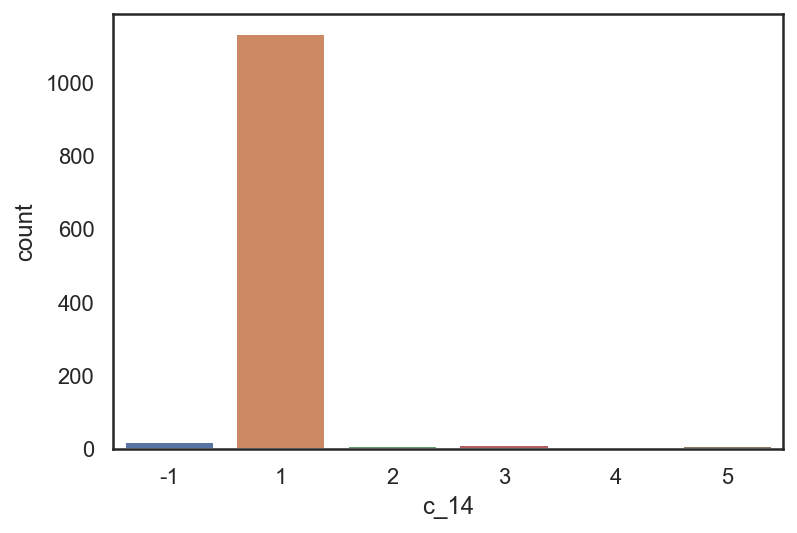

In [13]:
# 1이 절대다수인 것 재확인
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df_no_123[df_no_123["gap_c12_c14"]<0]["c_14"]);

### 먼저 절대다수인 c_14 == 1 부터 확인

In [14]:
# c_14 == 1인 데이터 확인 -> c_12 기준 데이터 수가 6 > 5 > 4 >3 > 2 순이다. 차례대로 확인
np.unique(df_no_123[df_no_123["gap_c12_c14"]<0]\
[df_no_123["c_14"]==1]["c_12"], return_counts=True)

(array([2, 3, 4, 5, 6]), array([  4,  16,  28, 177, 905]))

### (1) c_12 == 6

In [15]:
# 6부터 -> 6에서 1은 한 주기가 돌아온 것이며 사실상 gap은 1로, 모든 duration에 대해 가능 -> 문제없음
df_no_123[df_no_123["gap_c12_c14"]<0]\
[df_no_123["c_14"]==1][df_no_123["c_12"]==6]

,c_12,c_14,gap_c12_c14,c_13,c_25
24,6,1,-5,3,0
38,6,1,-5,2,0
41,6,1,-5,2,0
54,6,1,-5,2,1
55,6,1,-5,3,1
...,...,...,...,...,...
15861,6,1,-5,2,1
15870,6,1,-5,3,0
15917,6,1,-5,2,0
15931,6,1,-5,2,1


### (2) c_12 == 5

In [16]:
# 5 -> c_13은 1이 될 수 없음 -> 1가지 경우 존재
# 하지만 test 데이터라 지우지는 못함 (ㅠㅠ)
df_no_123[df_no_123["gap_c12_c14"]<0]\
[df_no_123["c_14"]==1][df_no_123["c_12"]==5]\
[df_no_123["c_13"]==1]

,c_12,c_14,gap_c12_c14,c_13,c_25
9837,5,1,-4,1,1


### (3) c_12 == 4

In [17]:
# 4 -> c_13은 1,2일 수 없음
# test 데이터 아닌 경우 6개 존재 -> 삭제 리스트에 추가

tmp = df_no_123[df_no_123["gap_c12_c14"]<0]\
[df_no_123["c_14"]==1][df_no_123["c_12"]==4]\
[df_no_123["c_13"].isin([1,2])]

list_for_del.extend(tmp[tmp["c_25"]==0].index)
tmp

,c_12,c_14,gap_c12_c14,c_13,c_25
43,4,1,-3,2,0
1504,4,1,-3,1,0
1762,4,1,-3,2,0
1766,4,1,-3,2,1
11706,4,1,-3,2,0
12031,4,1,-3,2,0
12665,4,1,-3,2,0


### (4) c_12 == 3

In [18]:
# 3 -> 여기부터는 c_13은 1,2,3일 수 없음
# test 데이터 아닌 경우 14개 존재 -> list_del 리스트에 추가

tmp = df_no_123[df_no_123["gap_c12_c14"]<0]\
[df_no_123["c_14"]==1][df_no_123["c_12"]==3]

list_for_del.extend(tmp[tmp["c_25"]==0].index)
tmp

,c_12,c_14,gap_c12_c14,c_13,c_25
480,3,1,-2,2,0
4515,3,1,-2,2,0
4651,3,1,-2,2,0
5921,3,1,-2,2,1
8596,3,1,-2,3,0
9904,3,1,-2,3,0
10635,3,1,-2,3,0
11104,3,1,-2,2,0
11120,3,1,-2,1,0
11420,3,1,-2,2,1


### (5) c_12 == 2

In [19]:
# 2 -> 위와 마찬가지고 c_13은 1,2,3일 수 없음
# test 데이터 아닌 경우 3개 존재 -> 삭제 리스트에 추가

tmp = df_no_123[df_no_123["gap_c12_c14"]<0]\
[df_no_123["c_14"]==1][df_no_123["c_12"]==2]

list_for_del.extend(tmp[tmp["c_25"]==0].index)
tmp

,c_12,c_14,gap_c12_c14,c_13,c_25
209,2,1,-1,2,0
268,2,1,-1,2,0
4782,2,1,-1,3,1
12132,2,1,-1,2,0


## 2) gap>0인 경우

In [20]:
# 이제 gap>0인 경우 확인 ->  (gap이 0은 오류가 없을 것이고, null값 처리는 여기서는 미고려)
np.unique(df_no_123[df_no_123["gap_c12_c14"]>0]["c_14"],
         return_counts=True)

(array([2, 3, 4, 5, 6]), array([  99,  110,  702, 1465, 1637]))

### c_14 == 2,3,4,5,6에 대해 차례대로 시행

### **** c_14 == 6 ****

In [21]:
sorted(df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==6]["c_12"].unique())

[1, 2, 3, 4, 5]

### (1) c_12 == 5

In [23]:
# c_12 == 5 -> 문제없음
df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==6][df_no_123["c_12"]==5]


,c_12,c_14,gap_c12_c14,c_13,c_25
84,5,6,1,2,0
85,5,6,1,2,0
97,5,6,1,2,1
104,5,6,1,3,0
118,5,6,1,2,1
...,...,...,...,...,...
15966,5,6,1,3,1
15972,5,6,1,3,0
15976,5,6,1,2,0
15984,5,6,1,3,1


### (2) c_12 == 4

In [25]:
# c_12 == 4 -> c_13은 1이 될 수 없음 -> 해당 경우 없음
df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==6][df_no_123["c_12"]==4].c_13.unique()

array([3, 2])

### (3) c_12 == 3

In [26]:
# c_12 == 3 -> c_13은 1,2일 수 없음 -> 2개 삭제리스트에 추가
tmp = df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==6][df_no_123["c_12"]==3]\
[df_no_123["c_13"].isin([1,2])]

list_for_del.extend(tmp[tmp["c_25"]==0].index)
tmp

,c_12,c_14,gap_c12_c14,c_13,c_25
8477,3,6,3,2,0
12705,3,6,3,2,0


### (4) c_12 == 2

In [27]:
# c_12 == 2 -> c_13은 1,2,3일 수 없음 -> 1개 삭제리스트에 추가
tmp = df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==6][df_no_123["c_12"]==2]

list_for_del.extend(tmp[tmp["c_25"]==0].index)
tmp

,c_12,c_14,gap_c12_c14,c_13,c_25
8514,2,6,4,3,0


### (5) c_12 == 1

In [28]:
# c_12 == 1 -> c_13은 1,2,3일 수 없음 -> 4개 삭제리스트에 추가
tmp = df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==6][df_no_123["c_12"]==1]

list_for_del.extend(tmp[tmp["c_25"]==0].index)
tmp

,c_12,c_14,gap_c12_c14,c_13,c_25
532,1,6,5,1,0
4158,1,6,5,3,0
5401,1,6,5,2,0
13077,1,6,5,3,0


### **** c_14 == 5 ****

In [29]:
sorted(df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==5]["c_12"].unique())

[1, 2, 3, 4]

### (1) c_12 == 4

In [30]:
# c_12 == 4 -> 문제없음
df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==5][df_no_123["c_12"]==4]

,c_12,c_14,gap_c12_c14,c_13,c_25
56,4,5,1,2,1
80,4,5,1,2,0
90,4,5,1,2,0
105,4,5,1,2,0
129,4,5,1,3,0
...,...,...,...,...,...
15955,4,5,1,2,1
15965,4,5,1,1,0
15978,4,5,1,2,1
15993,4,5,1,2,0


### (2) c_12 == 3

In [31]:
# c_12 == 3 -> c_13 == 1일 수 없음 -> 해당 경우 없음
df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==5][df_no_123["c_12"]==3].c_13.unique()

array([3, 2])

### (3) c_12 == 2

In [32]:
# c_12 == 2 -> c_13은 1,2가 될 수 없음 -> 해당 경우 없음
df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==5][df_no_123["c_12"]==2].c_13.unique()

array([3])

### (4) c_12 == 1

In [33]:
# c_12 == 1 -> c_13은 1,2,3일 수 없음 -> 5개 삭제리스트에 추가
tmp = df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==5][df_no_123["c_12"]==1]

list_for_del.extend(tmp[tmp["c_25"]==0].index)
tmp

,c_12,c_14,gap_c12_c14,c_13,c_25
4595,1,5,4,2,0
6839,1,5,4,1,0
11710,1,5,4,1,0
12377,1,5,4,2,0
15080,1,5,4,2,0


### **** c_14 == 4 ****

In [34]:
# c_12는 3가지 경우
sorted(df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==4]["c_12"].unique())

[1, 2, 3]

### (1) c_12 == 3

In [35]:
# c_12 == 3 -> 문제없음
df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==4][df_no_123["c_12"]==3]

,c_12,c_14,gap_c12_c14,c_13,c_25
30,3,4,1,3,0
124,3,4,1,3,0
125,3,4,1,1,0
139,3,4,1,2,0
151,3,4,1,2,0
...,...,...,...,...,...
15961,3,4,1,3,0
15969,3,4,1,2,1
15971,3,4,1,2,1
15973,3,4,1,2,0


### (2) c_12 == 2

In [36]:
# c_12 == 2 -> c_13은 1이 될 수 없음 -> 이상없음
df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==4][df_no_123["c_12"]==2].c_13.unique()

array([3, 2])

### (3) c_12 ==1

In [37]:
# c_12 == 1 -> c_13은 1,2가 될 수 없음 -> 6개 삭제 리스트 추가
tmp = df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==4][df_no_123["c_12"]==1]\
[df_no_123["c_13"].isin([1,2])]

list_for_del.extend(tmp[tmp["c_25"]==0].index)
tmp

,c_12,c_14,gap_c12_c14,c_13,c_25
1115,1,4,3,2,0
5398,1,4,3,2,0
5790,1,4,3,2,0
9523,1,4,3,1,0
9528,1,4,3,2,0
12050,1,4,3,1,0


### **** c_14 == 3 ****

In [38]:
# c_12는 2가지 경우
sorted(df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==3]["c_12"].unique())

[1, 2]

### (1) c_12 == 2

In [39]:
# c_12 == 2 -> 문제없음
df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==3][df_no_123["c_12"]==2]

,c_12,c_14,gap_c12_c14,c_13,c_25
169,2,3,1,3,0
239,2,3,1,2,0
335,2,3,1,3,0
566,2,3,1,3,1
593,2,3,1,3,0
...,...,...,...,...,...
15416,2,3,1,2,0
15499,2,3,1,2,1
15675,2,3,1,3,0
15710,2,3,1,3,0


### (2) c_12 == 1

In [40]:
# c_12 == 1 -> c_13은 1이 될 수 없음 -> 이상없음
df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==3][df_no_123["c_12"]==1].c_13.unique()

array([2, 3])

### **** c_14 == 2 ****

In [41]:
# c_12는 1가지 경우이며, 이 때 두 범주는 인접하므로 문제 가능성 없음
sorted(df_no_123[df_no_123["gap_c12_c14"]>0]\
[df_no_123["c_14"]==2]["c_12"].unique())

[1]

## 총 제거대상은 ** 41개 ** rows

In [42]:
# 총 제거대상은 41개 rows (혹시 몰라 중복제거도 실시)
len(set(list_for_del))

41